In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
import tensorflow as tf
from tensorflow.keras import layers, models

# URLs for the training and test datasets from UCI
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

In [3]:
def load_uci_digits(url):
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text), header=None)
    images = data.iloc[:, :-1].values.reshape(-1, 8, 8, 1).astype('float32') / 16.0
    labels = data.iloc[:, -1].values

    return images, labels

# Load and split data
train_images, train_labels = load_uci_digits(train_url)
test_images, test_labels = load_uci_digits(test_url)
images = np.concatenate([train_images, test_images], axis=0)
labels = np.concatenate([train_labels, test_labels], axis=0)
print(f"Total dataset shape: {images.shape}")

Total dataset shape: (5620, 8, 8, 1)


In [4]:
# Create a validation set
val_size = 1000
val_images = images[:val_size]
val_labels = labels[:val_size]
train_images = images[val_size:]
train_labels = labels[val_size:]
print(f"Training dataset shape: {train_images.shape}")
print(f"Validation dataset shape: {val_images.shape}")

Training dataset shape: (4620, 8, 8, 1)
Validation dataset shape: (1000, 8, 8, 1)


In [6]:
# A sample 8-bit message
message = np.array([1, 0, 1, 1, 0, 0, 1, 0], dtype='float32')
message = message.reshape(1, 8)  # Shape for model input
print("Sample message:", ' '.join(str(int(x)) for x in message.flatten()))

Sample message: 1 0 1 1 0 0 1 0


In [7]:
# Define Generator
def build_generator():
    input_image = layers.Input(shape=(8, 8, 1))
    input_message = layers.Input(shape=(8,))
    message_reshaped = layers.Reshape((8, 8, 1))(layers.Dense(64)(input_message))
    combined = layers.Concatenate()([input_image, message_reshaped])
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(combined)
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    output = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)

    return models.Model([input_image, input_message], output, name='generator')

# Define Discriminator
def build_discriminator():
    input_image = layers.Input(shape=(8, 8, 1))
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_image)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(input_image, output, name='discriminator')

# Define Extractor
def build_extractor():
    input_image = layers.Input(shape=(8, 8, 1))
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_image)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    output = layers.Dense(8, activation='sigmoid')(x)

    return models.Model(input_image, output, name='extractor')

In [8]:
generator = build_generator()
discriminator = build_discriminator()
extractor = build_extractor()

def bit_wise_accuracy(y_true, y_pred):
    bin = tf.round(y_pred)
    correct = tf.equal(y_true, bin)
    return tf.reduce_mean(tf.cast(correct, tf.float32))

# Compile Discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(2e-4),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Compile Extractor with custom metric
extractor.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=[bit_wise_accuracy])

In [9]:
# Build and compile GAN
discriminator.trainable = False
gan_input_image = layers.Input(shape=(8, 8, 1))
gan_input_message = layers.Input(shape=(8,))
stego_image = generator([gan_input_image, gan_input_message])
gan_output = discriminator(stego_image)
gan = models.Model([gan_input_image, gan_input_message], gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy')

In [10]:
# Generate random 8-bit messages
def generate_messages(batch_size):
    return np.random.randint(0, 2, size=(batch_size, 8)).astype('float32')

In [11]:
batch_size = 64
epochs = 20
perEpoch = len(train_images) // batch_size
lambdaVal = 1.0
g_optimizer = tf.keras.optimizers.Adam(1e-4)
d_losses, d_accs, g_losses, e_losses, e_accs, val_e_accs = [], [], [], [], [], []

for epoch in range(epochs):
    d_loss_total, d_acc_total, g_loss_total, e_loss_total, e_acc_total = 0, 0, 0, 0, 0

    for step in range(perEpoch):
        real_images = train_images[np.random.randint(0, len(train_images), batch_size)]
        messages = generate_messages(batch_size)

        stego_images = generator.predict([real_images, messages], verbose=0)

        rLables = np.zeros((batch_size, 1))
        fLables = np.ones((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_images, rLables)
        d_loss_fake = discriminator.train_on_batch(stego_images, fLables)
        d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        d_acc = 0.5 * (d_loss_real[1] + d_loss_fake[1])

        with tf.GradientTape() as tape:
            stego_images = generator([real_images, messages], training=True)
            fake_pred = discriminator(stego_images, training=False)
            gan_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(rLables, fake_pred))
            extracted_messages = extractor(stego_images, training=False)
            extraction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(messages, extracted_messages))
            g_loss = gan_loss + lambdaVal * extraction_loss

        grads = tape.gradient(g_loss, generator.trainable_weights)
        g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

        e_metrics = extractor.train_on_batch(stego_images, messages)
        e_loss = e_metrics[0]
        e_acc = e_metrics[1]

        d_loss_total += d_loss
        d_acc_total += d_acc
        g_loss_total += g_loss.numpy()
        e_loss_total += e_loss
        e_acc_total += e_acc

    # Calculate epoch averages
    d_loss_avg = d_loss_total / perEpoch
    d_acc_avg = d_acc_total / perEpoch
    g_loss_avg = g_loss_total / perEpoch
    e_loss_avg = e_loss_total / perEpoch
    e_acc_avg = e_acc_total / perEpoch

    # Validation metrics
    val_messages = generate_messages(val_size)
    val_stego_images = generator.predict([val_images, val_messages], verbose=0)
    val_metrics = extractor.evaluate(val_stego_images, val_messages, verbose=0)
    val_e_acc = val_metrics[1]

    d_losses.append(d_loss_avg)
    d_accs.append(d_acc_avg)
    g_losses.append(g_loss_avg)
    e_losses.append(e_loss_avg)
    e_accs.append(e_acc_avg)
    val_e_accs.append(val_e_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"D Loss: {d_loss_avg:.4f}, D Acc: {d_acc_avg:.4f}")
    print(f"G Loss: {g_loss_avg:.4f}")
    print(f"E Loss: {e_loss_avg:.4f}, E Acc: {e_acc_avg:.4f}")
    print(f"Val E Acc: {val_e_acc:.4f}")
    print("")

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/20
D Loss: 0.6782, D Acc: 0.5108
G Loss: 1.3500
E Loss: 0.6932, E Acc: 0.5056
Val E Acc: 0.5212

Epoch 2/20
D Loss: 0.6825, D Acc: 0.5012
G Loss: 1.3354
E Loss: 0.6928, E Acc: 0.5183
Val E Acc: 0.5435

Epoch 3/20
D Loss: 0.6866, D Acc: 0.5007
G Loss: 1.3203
E Loss: 0.6923, E Acc: 0.5371
Val E Acc: 0.5619

Epoch 4/20
D Loss: 0.6908, D Acc: 0.5005
G Loss: 1.2965
E Loss: 0.6891, E Acc: 0.5761
Val E Acc: 0.6050

Epoch 5/20
D Loss: 0.6958, D Acc: 0.5004
G Loss: 1.2621
E Loss: 0.6775, E Acc: 0.6170
Val E Acc: 0.6545

Epoch 6/20
D Loss: 0.7004, D Acc: 0.5003
G Loss: 1.2148
E Loss: 0.6465, E Acc: 0.6697
Val E Acc: 0.7059

Epoch 7/20
D Loss: 0.7043, D Acc: 0.5003
G Loss: 1.1554
E Loss: 0.5939, E Acc: 0.7082
Val E Acc: 0.7395

Epoch 8/20
D Loss: 0.7073, D Acc: 0.5002
G Loss: 1.0898
E Loss: 0.5357, E Acc: 0.7440
Val E Acc: 0.7744

Epoch 9/20
D Loss: 0.7099, D Acc: 0.5002
G Loss: 1.0303
E Loss: 0.4767, E Acc: 0.7827
Val E Acc: 0.8145

Epoch 10/20
D Loss: 0.7121, D Acc: 0.5002
G Loss: 0.975

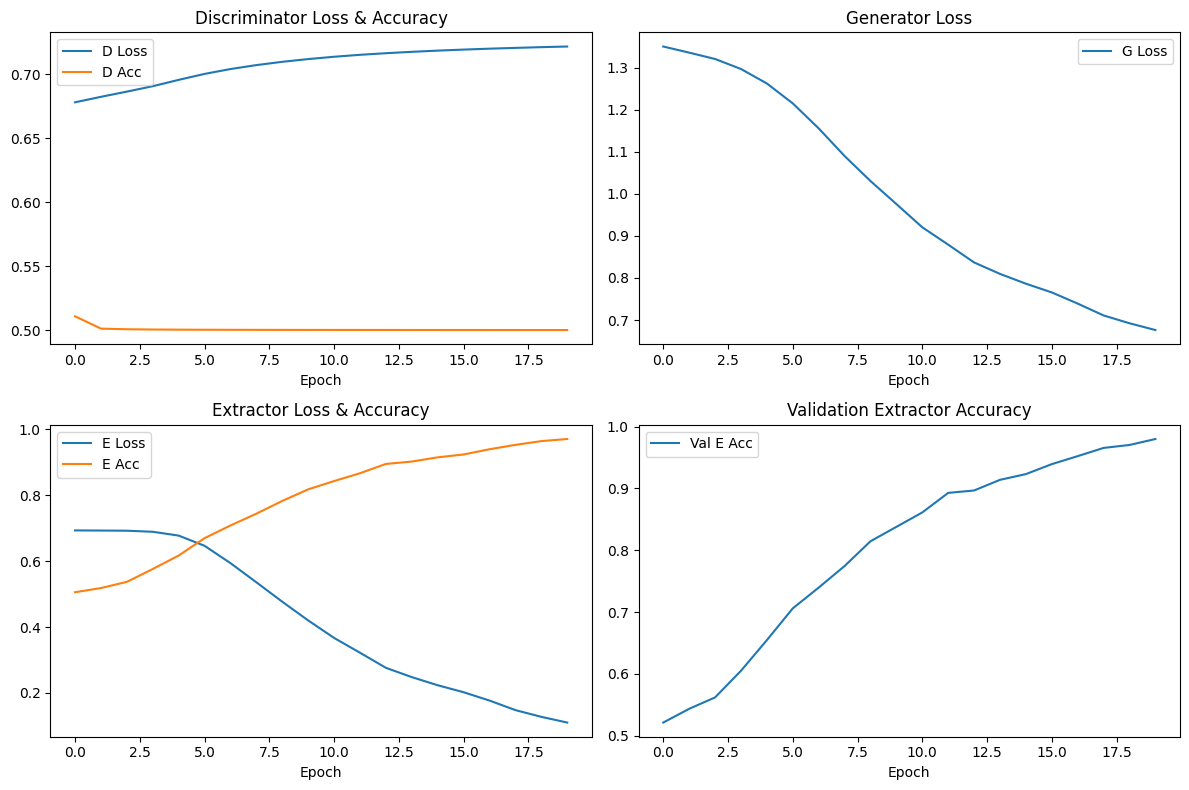

In [12]:
plt.figure(figsize=(12, 8))

# Plot 1: Discriminator Loss and Accuracy
plt.subplot(2, 2, 1)
plt.plot(d_losses, label="D Loss")
plt.plot(d_accs, label="D Acc")
plt.title("Discriminator Loss & Accuracy")
plt.xlabel("Epoch")
plt.legend()

# Plot 2: Generator Loss
plt.subplot(2, 2, 2)
plt.plot(g_losses, label="G Loss")
plt.title("Generator Loss")
plt.xlabel("Epoch")
plt.legend()

# Plot 3: Extractor Loss and Accuracy
plt.subplot(2, 2, 3)
plt.plot(e_losses, label="E Loss")
plt.plot(e_accs, label="E Acc")
plt.title("Extractor Loss & Accuracy")
plt.xlabel("Epoch")
plt.legend()

# Plot 4: Validation Extractor Accuracy
plt.subplot(2, 2, 4)
plt.plot(val_e_accs, label="Val E Acc")
plt.title("Validation Extractor Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()

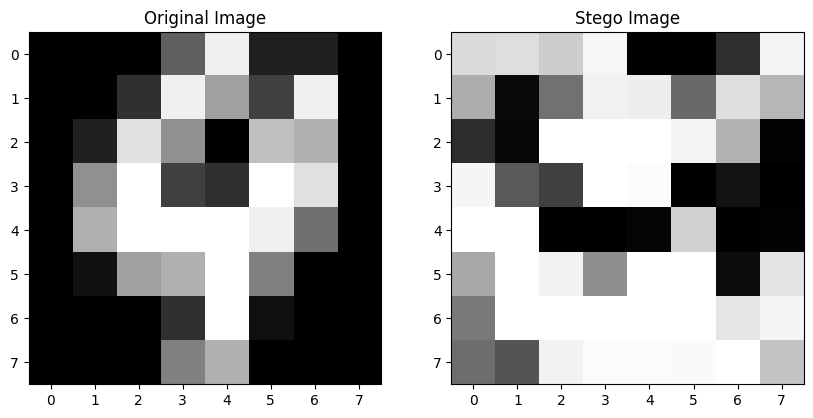

In [13]:
# Test multiple samples
num = 5
test_messages = generate_messages(num)
test_images = train_images[:num]

test_stego_images = generator.predict([test_images, test_messages], verbose=0)
test_extracted = extractor.predict(test_stego_images, verbose=0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_images[0].reshape(8, 8), cmap='gray')
plt.title("Original Image")
plt.axis('on')
plt.subplot(1, 2, 2)
plt.imshow(test_stego_images[0].reshape(8, 8), cmap='gray')
plt.title("Stego Image")
plt.axis('on')
plt.show()

Test 1:
Original Message: 0 1 1 1 1 1 0 0
Extracted Message: 0 1 1 1 1 1 0 0

Test 2:
Original Message: 1 0 1 0 0 1 0 1
Extracted Message: 1 0 1 0 0 1 0 1

Test 3:
Original Message: 0 1 1 1 0 1 1 1
Extracted Message: 0 1 1 1 0 1 1 1

Test 4:
Original Message: 0 1 0 1 1 1 0 0
Extracted Message: 0 1 0 1 1 1 0 0

Test 5:
Original Message: 1 1 1 0 1 0 1 1
Extracted Message: 1 1 1 0 1 0 1 1



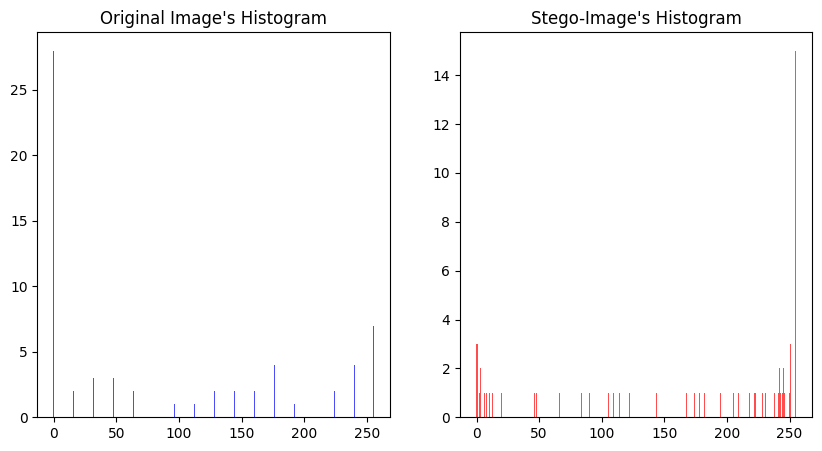

In [14]:
# Plot 6: Histogram Comparison
histIdx = 0
original_hist = np.histogram(test_images[histIdx].flatten(), bins=256, range=(0,1))[0]
stego_hist = np.histogram(test_stego_images[histIdx].flatten(), bins=256, range=(0,1))[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(256), original_hist, color='blue', alpha=0.7)
plt.title("Original Image's Histogram")

plt.subplot(1, 2, 2)
plt.bar(range(256), stego_hist, color='red', alpha=0.7)
plt.title("Stego-Image's Histogram")

for i in range(num):
    print(f"Test {i+1}:")
    original = ' '.join(str(int(x)) for x in test_messages[i])
    extracted = ' '.join(str(int(x)) for x in (test_extracted[i] > 0.5).astype(int))
    print(f"Original Message: {original}")
    print(f"Extracted Message: {extracted}")
    print("")
